In [1]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from os.path import isfile
from os import makedirs
import tarfile
import xml.dom.minidom
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import urllib

## Import data

The precompiled data is available on zenodo
This script will do fetch the data from zenodo, unless it already present

A detailed description how to deal with the raw data is given in the `README.md


### fetch and unpack data

In [2]:
# for download
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(
        unit="B",
        unit_scale=True,
        miniters=1,
        desc="Downloading " + url.split("/")[-1],
        bar_format="{desc}: {bar} {percentage: 3.0f}%",
        ncols=500,
    ) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)


if (
    isfile("data/low_glc/all.hdf5")
    and isfile("data/low_glc/fwd.hdf5")
    and isfile("data/high_glc/all.hdf5")
    and isfile("data/high_glc/fwd.hdf5")
):
    # the precomputed data is present, we can continue
    pass
else:
    # Download and unpack the data
    if not isfile("data.tar.bz2"):
        download_url(
            "https://zenodo.org/record/7896186/files/data.tar.bz2", "data.tar.bz2"
        )
    with tarfile.open("data.tar.bz2", "r:bz2") as tar:
        tar.extractall()

### prepare folders

In [3]:
makedirs("out", exist_ok=True)

### open hdf5 files and read in flux and simulated measurement data

In [4]:
# create a pandas dataframe with column labels from the data inside the hdf5
# rows are MC samples, columns are fluxes/measurements
def create_dataframe_from_hdf5(hdf_name, data_path, name_path):
    with h5py.File(hdf_name) as hdf:
        names = [x.decode("utf-8") for x in hdf.get(name_path)[0]]
        data = np.transpose(hdf.get(data_path)[()])

    return pd.DataFrame(data=data, columns=names)


# some constants for the path names inside the hdf5
FLUX_ALL_DATA = "/parameter/all_data"
FLUX_ALL_NAMES = "/parameter/all_names"

FLUX_DATA = "/parameter/data"
FLUX_NAMES = "/parameter/names"

MEAS_DATA = "/measurements/data"
MEAS_NAMES = "/measurements/names"

CONDITIONS = ["low", "high"]

# the (arbitrary) growth rate used in the model. Here we use it for normalizing
MU = 0.35

# contains flux data
fluxes = {}
# contains simulated MS measurement data
simdata = {}

for i in CONDITIONS:
    fluxes[i] = create_dataframe_from_hdf5(
        f"data/{i}_glc/fwd.hdf5", FLUX_ALL_DATA, FLUX_ALL_NAMES
    )
    simdata[i] = create_dataframe_from_hdf5(
        f"data/{i}_glc/fwd.hdf5", MEAS_DATA, MEAS_NAMES
    )

### read in measured data from FluxML file

In [5]:
# will contain the measurement data, with the group id as a key
# the fml model has two configurations one for eacht glucose
# concentration. As the group ids differ, we put them in the same
# dict
measdata = {}
# parse the
fml_tree = xml.dom.minidom.parse("ressources/STm_model.fml")

# get all groups
fml_groups = fml_tree.getElementsByTagName("group")
# extract the data
for group in fml_groups:
    mid = group.getAttribute("id")
    # this describes what was measured
    name_raw = group.getElementsByTagName("textual")[0].firstChild.nodeValue
    # we split at the '#' to get the metabolite and the masses
    name, masses = name_raw.split("#")
    num_masses = len(masses.split(","))
    # we prepare the actual measurement data
    measdata[mid] = [name, np.zeros((num_masses, 2))]

# get the actual data, one datum for every ms trace
fml_datum = fml_tree.getElementsByTagName("datum")
for datum in fml_datum:
    mid = datum.getAttribute("id")
    weight = int(datum.getAttribute("weight"))
    stddev = float(datum.getAttribute("stddev"))
    val = float(datum.firstChild.nodeValue)
    measdata[mid][1][weight, :] = [val, stddev]

#### map mids between low and high glc concentration

the group ids for the high glc concentration have an offset to the ones with the low concentration

In [6]:
group_map = {}
for mid in measdata:
    for mid2 in measdata:
        if (
            (mid != mid2)
            and (measdata[mid][0] == measdata[mid2][0])
            and (int(mid.split("_")[2]) < 17)
        ):
            group_map[mid] = mid2

## Figures/Data for main Text

First some general preparation.
In the model file names of the reactions are not always as in submitted manuscript. 
This dictionary converts them.

In [7]:
PW_GLYCOLYSIS = "glycolysis"
PW_EDP = "EDP"
PW_PPP = "PPP"
PW_UPT = "uptake"
PW_DENOVO = " de novo \nsynthesis"
flux_dict = {
    "PGI.n": {"name": "pgi", "pw": PW_GLYCOLYSIS},
    "PFK_A__PFK_B.n": {"name": "pfkA/B\nfbp", "pw": PW_GLYCOLYSIS},
    "FBA.n": {"name": "fba/B", "pw": PW_GLYCOLYSIS},
    "TPI.n": {"name": "tpiA", "pw": PW_GLYCOLYSIS},
    "GAPDH.n": {"name": "gapA", "pw": PW_GLYCOLYSIS},
    "EDP.n": {"name": "edp", "pw": PW_EDP},
    "zwf.n": {"name": "zwf", "pw": PW_PPP},
    "PGD.n": {"name": "pgl gnd", "pw": PW_PPP},
    "RPE.n": {"name": "rpe", "pw": PW_PPP},
    "RPI.n": {"name": "rpiA", "pw": PW_PPP},
    "TKT1.n": {"name": "tktA1/B1", "pw": PW_PPP},
    "TKT2.n": {"name": "tktA2/B2", "pw": PW_PPP},
    "TAL.n": {"name": "talA/B", "pw": PW_PPP},
    "upt_mtl.n": {"name": "Mtl", "pw": PW_UPT},
    "upt_glcn.n": {"name": "Glcn", "pw": PW_UPT},
    "glp.n": {"name": "Glyc", "pw": PW_UPT},
    "upt_Ade.n": {"name": "Ade", "pw": PW_UPT},
    "upt_Gua.n": {"name": "Gua", "pw": PW_UPT},
    "upt_Cyto.n": {"name": "Cyto", "pw": PW_UPT},
    "upt_Ura.n": {"name": "Ura", "pw": PW_UPT},
    "upt_g6p.n": {"name": "Glc/Glc6P", "pw": PW_UPT},
    "mtlD.n": {"name": "mtlD", "pw": PW_UPT},
    "rbsK.n": {"name": "Rib", "pw": PW_UPT},
    "upt_pyr.n": {"name": "Pyr", "pw": PW_UPT},
    "bsUMP.n": {"name": "UMP", "pw": PW_DENOVO},
    "bsCMP.n": {"name": "CMP", "pw": PW_DENOVO},
    "bsGMP.n": {"name": "GMP", "pw": PW_DENOVO},
    "bsAMP.n": {"name": "AMP", "pw": PW_DENOVO},
}

some colors from the omix model
Colors are in that order

In [8]:
alpha = "cc"
pathway_colors = {
    PW_GLYCOLYSIS: "#ef1a1c" + alpha,
    PW_EDP: "#aaaaff" + alpha,
    PW_PPP: "#ff7f00" + alpha,
    PW_UPT: "#60e5e7" + alpha,
    PW_DENOVO: "#d2a854" + alpha,
}

### Figure 4 flux map with CrIs

The actual figure is produced with an OVL script in Omix. Its Input is a `csv` file with all needed data. This file is generated here

In [9]:
# get the names of all net fluxes and remove the trailing ".n"
net_flux_names = [x[:-2] for x in fluxes[CONDITIONS[0]].filter(like=".n").columns]
# omix expects the EV to be in column labeled x (where x is the flux names)
# the lower bound is at x_l and the upper bound at x_u. Here we construct this column headers
column_heads = np.hstack([[x, x + "_l", x + "_u"] for x in net_flux_names])
omix_vals = pd.DataFrame(index=CONDITIONS, columns=column_heads)

for i in CONDITIONS:
    net_fluxes = fluxes[i].filter(like=".n")
    # compute EV and bounds
    expected_values = net_fluxes.mean()
    lower_bounds = net_fluxes.quantile(q=0.025)
    upper_bounds = net_fluxes.quantile(q=0.975)
    for flux in net_fluxes.columns:
        short_flux = flux[:-2]
        omix_vals.loc[i, short_flux] = expected_values.loc[flux]
        omix_vals.loc[i, short_flux + "_l"] = lower_bounds.loc[flux]
        omix_vals.loc[i, short_flux + "_u"] = upper_bounds.loc[flux]
omix_vals.to_csv("out/Fig_4_omix.csv")

## Figures / Data for Supplement

### Figure S05 A

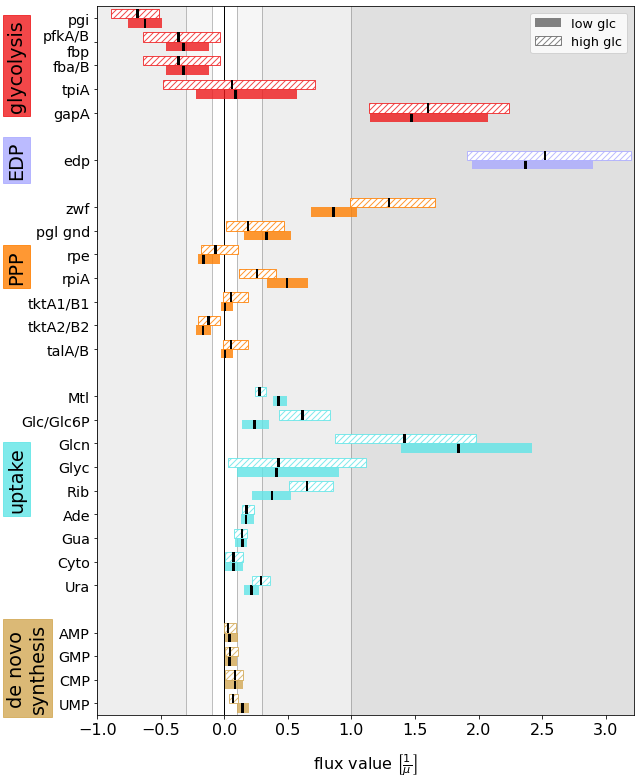

In [10]:
# fluxes to include in the plot in that order
fluxes_to_show = [
    "PGI.n", "PFK_A__PFK_B.n", "FBA.n", "TPI.n", "GAPDH.n", # glycolysis: 5
    "EDP.n", # EDP : 1
    "zwf.n", "PGD.n", "RPE.n", "RPI.n", "TKT1.n", "TKT2.n", "TAL.n", # PPP: 7
    "upt_mtl.n", "upt_g6p.n", "upt_glcn.n", "glp.n", "rbsK.n", "upt_Ade.n",
    "upt_Gua.n", "upt_Cyto.n", "upt_Ura.n", # uptake : 9
    "bsAMP.n", "bsGMP.n", "bsCMP.n", "bsUMP.n", # by : 4
]
# nice names for the fluxes, and the flux colors
flux_lab = [flux_dict[x]["name"] for x in fluxes_to_show]
colors = [pathway_colors[flux_dict[x]["pw"]] for x in fluxes_to_show]

# the cutoffs as used in Fig 4
borders = np.array([0.1, 0.3, 1])
# colors for the corresponding zones
lg = "#f6f6f6"
mg = "#eeeeee"
dg = "#e0e0e0"

# position of the hbars for the fluxes
# like in fluxes_to_show
pos = -np.array(
    [
        0, 1, 2, 3, 4, 
        6,
        8, 9, 10, 11, 12, 13, 14,
        16, 17, 18, 19, 20, 21, 22, 23, 24,
        26, 27, 28, 29,
    ]
)
# position of the minor tic labels, i.e. the pathway names
pos_min = -np.array([2.01, 6.01, 10.51, 19.51, 27.51])
fs = 16

pathways = [PW_GLYCOLYSIS, PW_EDP, PW_PPP, PW_UPT, PW_DENOVO]

plt.figure(figsize=(9, 11))
# some constants for drawing
BAR_HEIGHT = 2 / 5
EV_WIDTH = 0.02

# First plot the cutoff zones
# positive part
plt.axvspan(xmin=borders[0], xmax=borders[1], fc=lg)
plt.axvspan(xmin=borders[1], xmax=borders[2], fc=mg)
plt.axvspan(xmin=borders[2], xmax=3.3, fc=dg)
# negative part
plt.axvspan(xmin=-borders[1], xmax=-borders[0], fc=lg)
plt.axvspan(xmin=-borders[2], xmax=-borders[1], fc=mg)

# legend for low and high
leg_l = None
leg_h = None

# a positional offset for the bars
bar_offset = -1

for c in CONDITIONS:
    # first plot the CrIs
    bc = plt.barh(
        y=pos + bar_offset * BAR_HEIGHT / 2,
        left=fluxes[c].loc[:, fluxes_to_show].quantile(q=0.025) / MU,
        width=(
            fluxes[c].loc[:, fluxes_to_show].quantile(q=0.975)
            - fluxes[c].loc[:, fluxes_to_show].quantile(q=0.025)
        )
        / MU,
        height=BAR_HEIGHT,
        color=colors,
        zorder=3,
    )
    # then a black line at the EV
    bce = plt.barh(
        y=pos + bar_offset * BAR_HEIGHT / 2,
        left=fluxes[c].loc[:, fluxes_to_show].mean() / MU - EV_WIDTH / 2,
        width=EV_WIDTH,
        height=BAR_HEIGHT,
        color="black",
        zorder=3,
    )
    # some plot formatting
    for b, be in zip(bc, bce):
        if c == CONDITIONS[0]:
            # get handle for legend
            leg_l = bc[0]
        else:
            # make bars for high glucose hatched
            b.set(edgecolor=b.get_facecolor(), hatch="////")
            # be.set(edgecolor='black')
            # b.fill = False
            b.set(facecolor="white")
            # get handle for legend
            leg_h = bc[0]
    # next bars go 2*BAR_HEIGTH/2 down
    bar_offset += 2

# add lines to the cutoff zones
# first at 0
plt.vlines(x=0, ymin=pos.min() - 0.5, ymax=pos.max() + 0.5, color="black", linewidth=1)
# then the rest
plt.vlines(
    x=borders,
    ymin=pos.min() - 0.5,
    ymax=pos.max() + 0.5,
    color="gray",
    linewidth=0.5,
    zorder=1,
)
plt.vlines(
    x=-borders, ymin=pos.min() - 0.5, ymax=pos.max() + 0.5, color="gray", linewidth=0.5
)

# set flux labels at every bar
plt.yticks(ticks=pos, labels=flux_lab, fontsize=0.9 * fs)
# format the plot
plt.ylim([pos.min() - 0.5, pos.max() + 0.5])
plt.xticks(fontsize=fs)
plt.xlim([-1, 3.22])
plt.xlabel(r"flux value $\left[\frac{1}{\mu}\right]$", fontsize=fs, labelpad=14)

# pathway label at preset position
plt.gca().set_yticks(pos_min, minor=True)
plt.gca().tick_params(
    which="minor", axis="y", pad=90, labelrotation=90, length=0, width=0
)
plt.gca().set_yticklabels(
    pathways, minor=True, va="center", ha="left", fontsize=1.2 * fs
)
xmin_labs = plt.gca().get_yticklabels(minor=True)

# background color for pw label
for lab in xmin_labs:
    lab.set_backgroundcolor(pathway_colors[lab.get_text()])

# make the bars in the legend grey
alpha = "cc"
leg_l.set(fc="#646464" + alpha)
leg_h.set(edgecolor="#646464" + alpha)

leg = plt.legend(
    handles=[leg_l, leg_h], labels=["low glc", "high glc"], fontsize=0.8 * fs
)

# now also the first bars are grey, so we change them back
leg_l.set(fc=pathway_colors[flux_dict[fluxes_to_show[0]]["pw"]])
leg_h.set(edgecolor=pathway_colors[flux_dict[fluxes_to_show[0]]["pw"]])
plt.tight_layout()
plt.savefig("out/Fig_S05A_low_v_high.svg")
plt.savefig("out/Fig_S05A_low_v_high.png")

### Fig S10

predictive posteriors, i.e. the simulated measurements generated from all the samples from the MCMC runs.

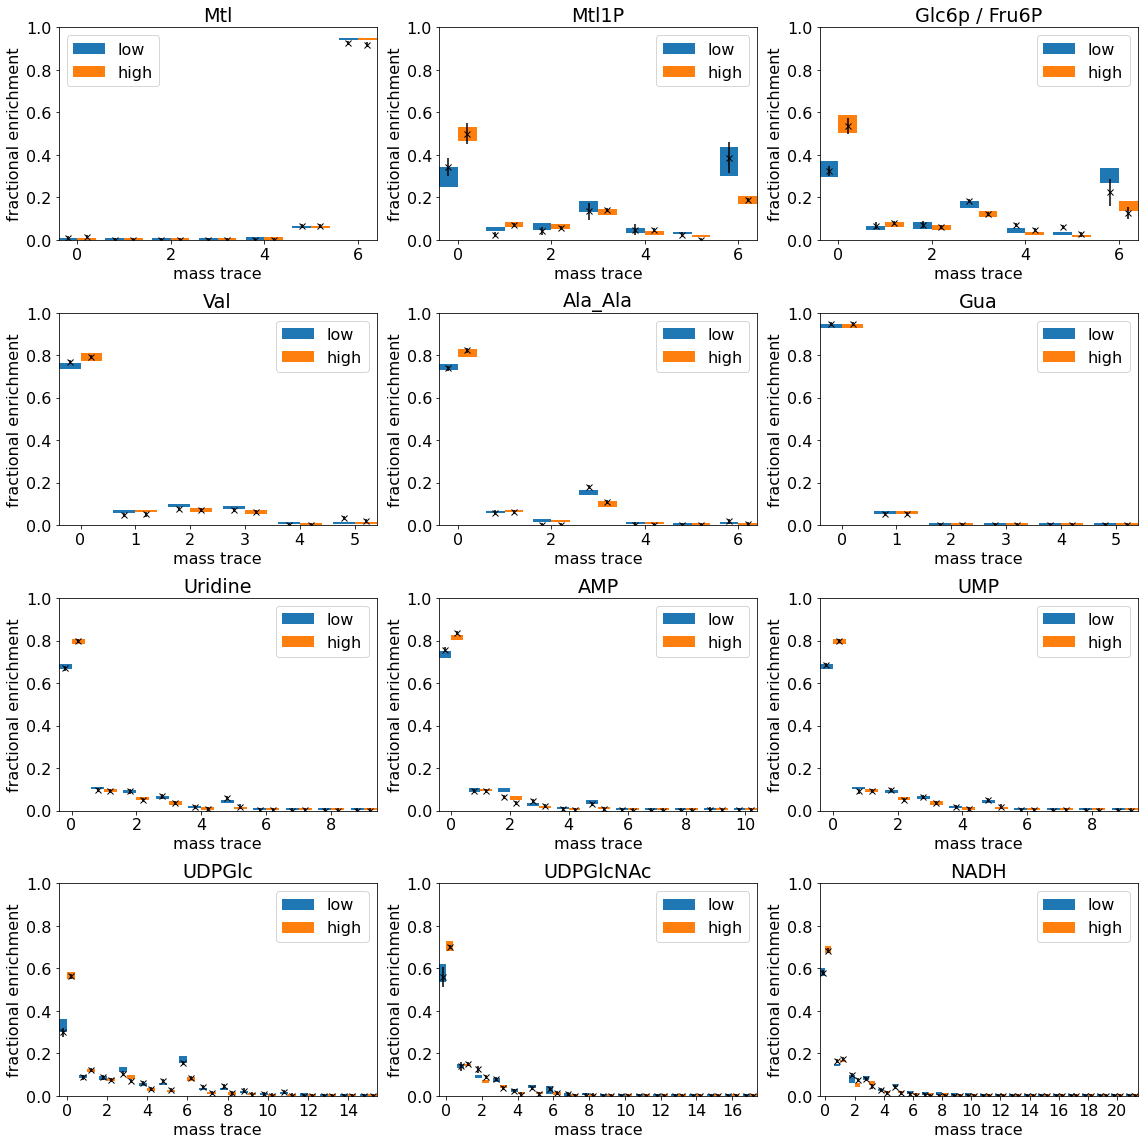

In [11]:
# translation between names in model and on the figure
metabolite_dict = {
    "MTL": "Mtl",
    "M1P": "Mtl1P",
    "H6P": "Glc6p / Fru6P",
    "VAL": "Val",
    "ALA_ALA": "Ala_Ala",
    "GMP[2,4,7,8,10]": "Gua",
    "UMP_1": "Uridine",
    "UMP": "UMP",
    "AMP": "AMP",
    "UDPGlc": "UDPGlc",
    "UDPGlcNAc": "UDPGlcNAc",
    "NAD": "NADH",
}


# makes a comparision plot
def plot_comparison(mid_low, ax, fs):
    # get the mid for the high glucose concentration
    mid_high = group_map[mid_low]
    # and the plain name i.e. the measured metabolite
    plain_name = measdata[mid_low][0]
    # disentalge UMP and Uridine
    if mid_low == "ms_group_4":
        plain_name += "_1"

    # get the measured data (+stddev) for both glucose concentrations
    data_low = measdata[mid_low][1]
    data_high = measdata[mid_high][1]
    masses = np.arange(data_low.shape[0])

    # prepare for retrieving the simulated data. First build the column entries
    entries_low = [f"{mid_low}_{i}" for i in masses]
    entries_high = [f"{mid_high}_{i}" for i in masses]

    # caculate the 95% range of the simulated measurements
    # and put them in the right format (lower value and the range)
    # for optical reasons there is a lower value for the range
    b_low = simdata[CONDITIONS[0]].loc[:, entries_low].quantile(q=0.025)
    h_low = simdata[CONDITIONS[0]].loc[:, entries_low].quantile(q=0.975) - b_low
    h_low = np.maximum(h_low, 0.01)

    b_high = simdata[CONDITIONS[1]].loc[:, entries_high].quantile(q=0.025)
    h_high = simdata[CONDITIONS[1]].loc[:, entries_high].quantile(q=0.975) - b_high
    h_high = np.maximum(h_high, 0.01)

    # plot the bars for low and high glucose
    ax.bar(x=masses - 0.2, height=h_low, bottom=b_low, width=0.4)
    ax.bar(x=masses + 0.2, height=h_high, bottom=b_high, width=0.4)

    # now the measured values as errorbars
    ax.errorbar(masses - 0.2, data_low[:, 0], yerr=data_low[:, 1], fmt="kx")
    ax.errorbar(masses + 0.2, data_high[:, 0], yerr=data_high[:, 1], fmt="kx")

    # get integer ticks
    max_mass = np.max(masses)
    if max_mass > 6:
        ticks = np.arange(start=0, stop=max_mass + 1, step=2)
        ax.set_xticks(ticks=ticks)
    ax.set_xlim([0 - 2 * 0.2, max_mass + 2 * 0.2])

    # nice titles, legends and so on
    if plain_name in metabolite_dict:
        ax.set_title(f"{metabolite_dict[plain_name]}", fontsize=1.2 * fs)
    else:
        ax.set_title(f"{plain_name}")
    ax.legend(["low", "high"], fontsize=fs)
    ax.set_xlabel("mass trace", fontsize=fs)
    ax.set_ylabel("fractional enrichment", fontsize=fs)
    ax.tick_params(axis="both", labelsize=fs)
    # finally make yrange identical
    ax.set_ylim([0, 1])

    # now collect the data in a dataframe
    out = pd.DataFrame(
        index=[
            "sim low lb",
            "sim low ub",
            "meas low",
            "meas low stddev",
            "sim high lb",
            "sim high ub",
            "meas high",
            "meas high stddev",
        ],
        columns=[f"M+{x}" for x in masses],
    )
    out.loc["sim low lb"] = np.array(b_low)
    out.loc["sim low ub"] = np.array(b_low + h_low)
    out.loc["sim high lb"] = np.array(b_high)
    out.loc["sim high ub"] = np.array(b_high + h_high)
    out.loc["meas low"] = data_low[:, 0]
    out.loc["meas low stddev"] = data_low[:, 1]
    out.loc["meas high"] = data_high[:, 0]
    out.loc["meas high stddev"] = data_high[:, 1]
    return out


# the ms groups of interest
ms_groups = [f"ms_group_{i}" for i in [8, 9, 16, 0, 12, 3, 4, 5, 6, 7, 13, 14]]
# open an xlsx file
with pd.ExcelWriter("out/Data_for_Fig_S10.xlsx") as writer:
    fs = 16
    # create figure
    fig = plt.figure(figsize=(16, 16))
    # index of the current subplot
    plot_idx = 1

    for mid_low in ms_groups:
        # select subplot and plot the comparison
        ax = plt.subplot(4, 3, plot_idx)
        out = plot_comparison(mid_low, ax, fs)
        # write data to excel file
        out.to_excel(writer, metabolite_dict[measdata[mid_low][0]].replace("/", ""))
        plot_idx += 1

plt.tight_layout()
plt.savefig("out/Fig_S10_predictive_posterior.svg")
plt.savefig("out/Fig_S10_predictive_posterior.png")

## Table S2

probability, that a specific flux runs in forward/backward direction

In [12]:
# for which fluxes we calculate the probabilities
fluxes_for_dir = ["mtlD", "PGI", "RPE", "TKT2", "TAL", "PFK_A__PFK_B",
                  "FBA", "GAPDH", "RPI", "TKT1", "TPI"]

# some epsilon, which is considered non zero
EPS = 1e-5

# create dataframe with the probabilities
probs = pd.DataFrame(
    index=[flux_dict[x + ".n"]["name"] for x in fluxes_for_dir],
    columns=[
        "bwd flux low",
        "bwd flux high",
        "fwd flux low",
        "fwd flux high",
        "principal dir low",
        "principal dir high",
    ],
)
num_samples = fluxes[CONDITIONS[0]].shape[0]

for cond in CONDITIONS:
    for flux in fluxes_for_dir:
        net_name = flux + ".n"
        # count number of positive and negative net fluxes
        neg = fluxes[cond][fluxes[cond].loc[:, net_name] < 0].shape[0]
        pos = fluxes[cond][fluxes[cond].loc[:, net_name] > 0].shape[0]

        # calculate principal direction of net flux, if any
        p_dir = "?"
        if neg / num_samples >= 0.95:
            p_dir = "bwd"
        elif pos / num_samples >= 0.95:
            p_dir = "fwd"
        probs.loc[flux_dict[flux + ".n"]["name"], f"principal dir {cond}"] = p_dir

        # if the net flux is negative (positive) and xch is non zero, ther is also a fwd (bwd) flux
        xch_name = flux + ".x"
        if xch_name in fluxes[cond].columns:
            pos += fluxes[cond][
                (fluxes[cond].loc[:, net_name] < 0)
                & (fluxes[cond].loc[:, xch_name] > EPS)
            ].shape[0]
            neg += fluxes[cond][
                (fluxes[cond].loc[:, net_name] > 0)
                & (fluxes[cond].loc[:, xch_name] > EPS)
            ].shape[0]

        # fill in data in dataframe
        probs.loc[flux_dict[flux + ".n"]["name"], f"bwd flux {cond}"] = np.round(
            neg / num_samples * 100
        )
        probs.loc[flux_dict[flux + ".n"]["name"], f"fwd flux {cond}"] = np.round(
            pos / num_samples * 100
        )

probs.to_excel("out/Table_S2_flux_directions.xlsx")

## Figs S8 and S9

Here we need different raw data. The results from the forwardsimulation are in a different order. The data in `all.hdf5`is still intact, so we can just chop it up

In [13]:
fluxes_raw = {}
NUM_CHAINS = 10

for cond in CONDITIONS:
    temp = create_dataframe_from_hdf5(
        f"data/{cond}_glc/all.hdf5", FLUX_DATA, FLUX_NAMES
    )
    total_samples = temp.shape[0]
    samples_per_chain = int(total_samples / NUM_CHAINS)
    # chop the samples up, so we can access the samples from each run individually
    fluxes_raw[cond] = [None] * NUM_CHAINS
    for chain in np.arange(NUM_CHAINS):
        fluxes_raw[cond][chain] = temp.iloc[
            np.arange(samples_per_chain) + chain * samples_per_chain, :
        ]

### Fig S8

mixing plots of the free net fluxes in parameter space for the first replicate

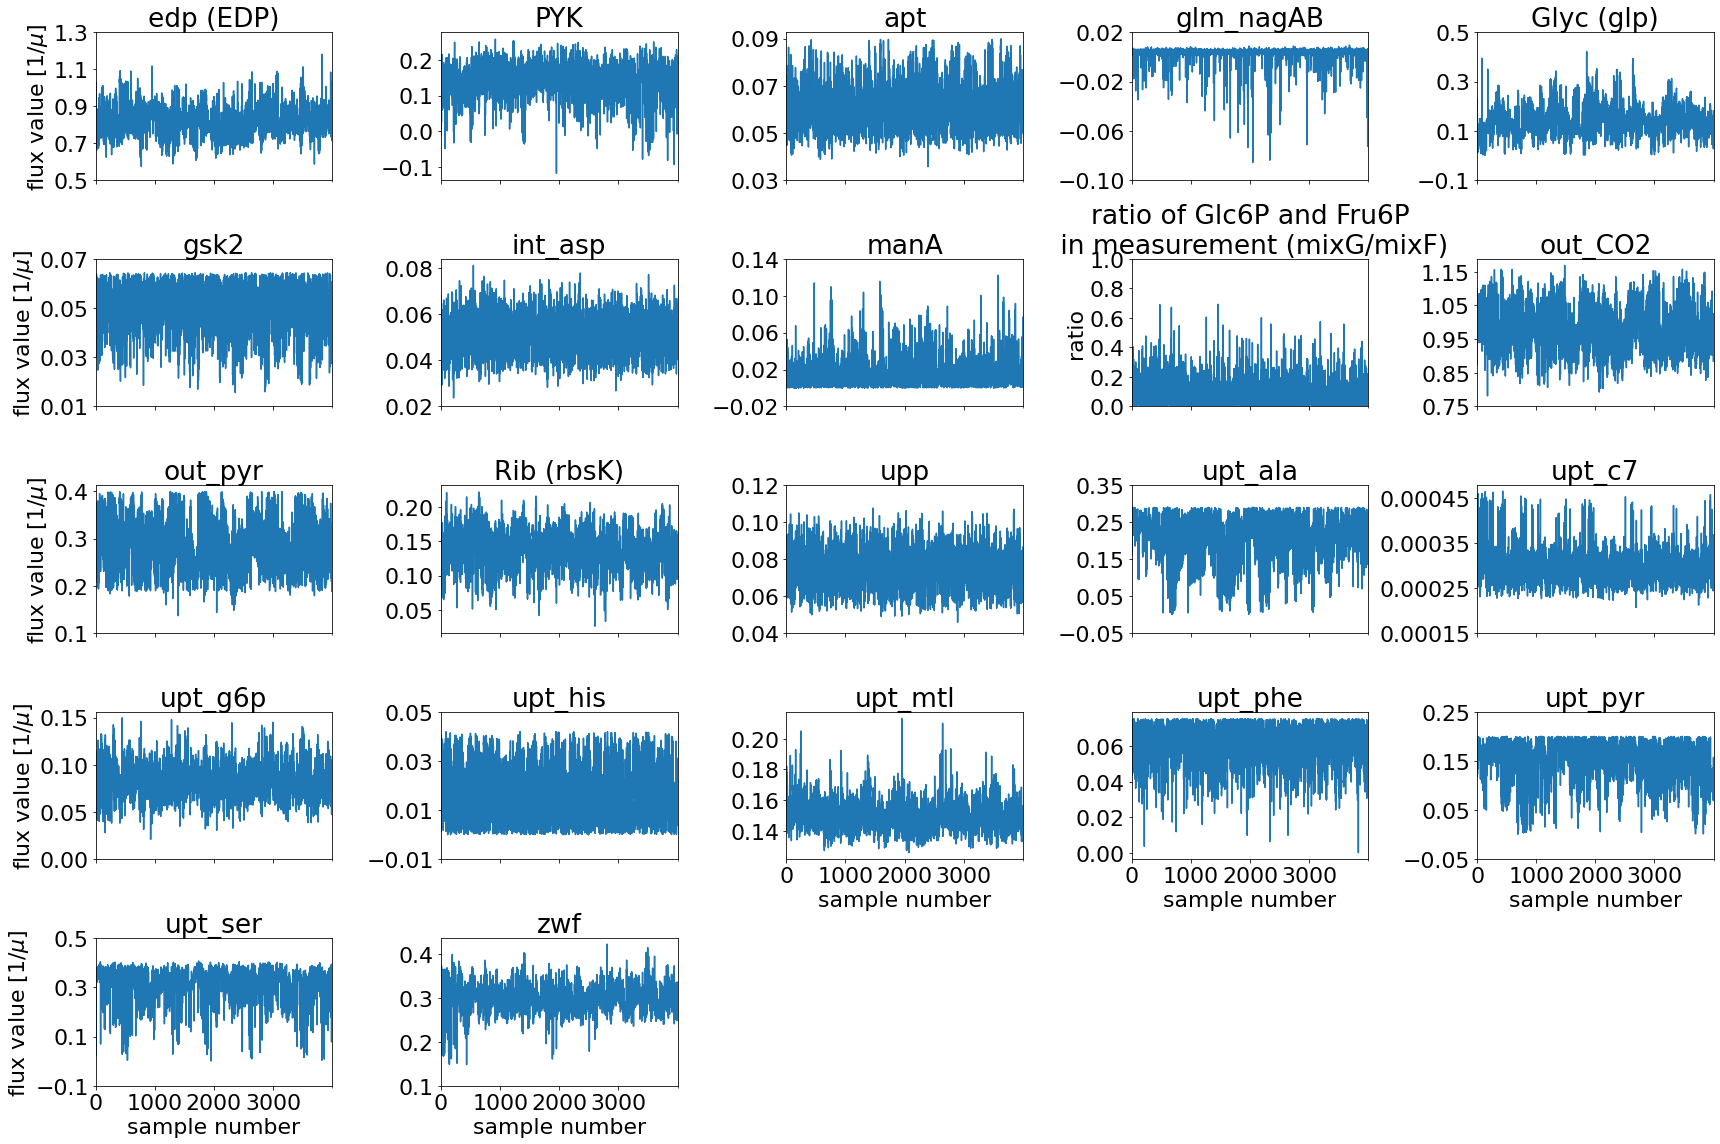

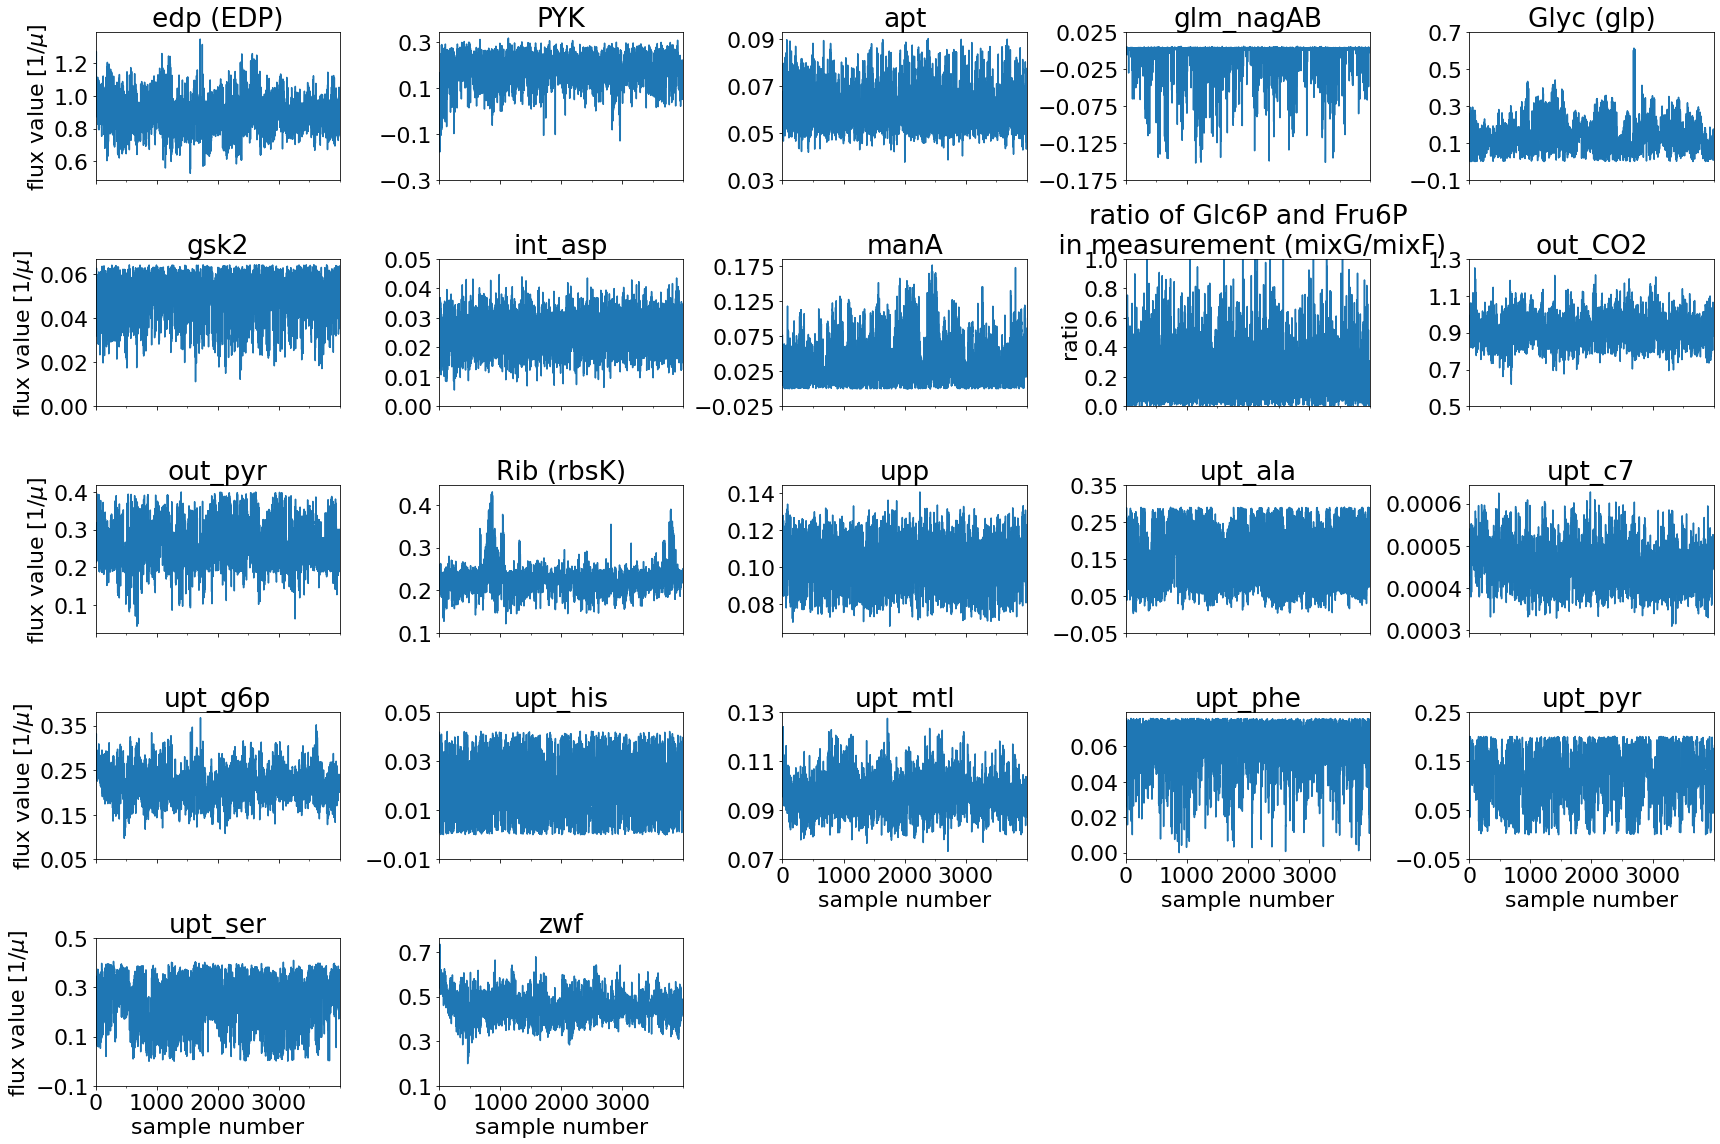

In [14]:
REPLICATE = 3

for cond in CONDITIONS:
    # get all free net fluxes
    net_flux_data = fluxes_raw[cond][REPLICATE].filter(like=".n", axis=1).copy()
    net_flux_data.reset_index(drop=True, inplace=True)

    # transform some free fluxes to something that is easier to understand

    # upt_c7 is what leads to upt_nad, 3 C7 units make up one nad
    net_flux_data.loc[:, "upt_c7.n"] = 1 / 3 * net_flux_data.loc[:, "upt_c7.n"]
    net_flux_data.rename(columns={"upt_c7.n": "upt_nad.n"})

    # mixG and mixF are the proportions of G6P and F6P in the joint H6P measurement.
    # here we normalize them
    net_flux_data.loc[:, "mixG.n"] = net_flux_data.loc[:, "mixG.n"] / (
        1e-5 - net_flux_data.loc[:, "mixG.n"]
    )

    # prepare plot
    cols = 5
    fac = 3.2
    rows = int(np.ceil(len(net_flux_data.columns) / cols))
    fs = 22

    # plot
    axs = net_flux_data.plot(
        subplots=True,
        layout=(rows, cols),
        figsize=(fac * 1.5 * cols, fac * rows),
        sharex=True,
        legend=False,
        title=net_flux_data.columns.array,
        color="#1f77b4",
        fontsize=fs,
    )

    # format
    ticks = np.arange(start=0, stop=net_flux_data.shape[0], step=1000)
    for axr in axs:
        first_c = True
        for axp in axr:
            axp.set_xlabel("sample number", fontsize=fs)
            if first_c:
                axp.set_ylabel(r"flux value $\left[1 / \mu \right]$", fontsize=fs)
                first_c = False
            axp.set_xticks(ticks)
            title = axp.get_title()[:-2]
            # change titles of transformed parameter
            if title == "upt_nad":
                title = r"upt_NAD ($\frac{1}{3}\times$ upt_c7)"
            if title == "mixG":
                title = f"ratio of Glc6P and Fru6P\n in measurement (mixG/mixF)"
                axp.set_ylabel("ratio", fontsize=fs)
                axp.set_ylim([0, 1])
            title_n = title + ".n"
            if (
                title_n in flux_dict
                and not flux_dict[title_n]["name"] == title
                and not "upt_" in title_n
            ):
                str_name = "name"
                title = f"{flux_dict[title_n][str_name]} ({title})"
            axp.set_title(title, fontdict={"fontsize": 1.2 * fs})

            yticks = axp.get_yticks()
            if len(yticks) > 6:
                yticks = yticks[np.arange(0, len(yticks), 2)]
                axp.set_yticks(yticks)
            axp.set_xlim([0, net_flux_data.shape[0]])

        plt.tight_layout()

        part = "A"
        if cond == CONDITIONS[1]:
            part = "B"
        plt.savefig(f"out/Fig_S08{part}_mixing_plot.svg")
        plt.savefig(f"out/Fig_S08{part}_mixing_plot.png")
        plt.savefig(f"out/Fig_S08{part}_mixing_plot.pdf")

### Fig S9

mixing plot in model space

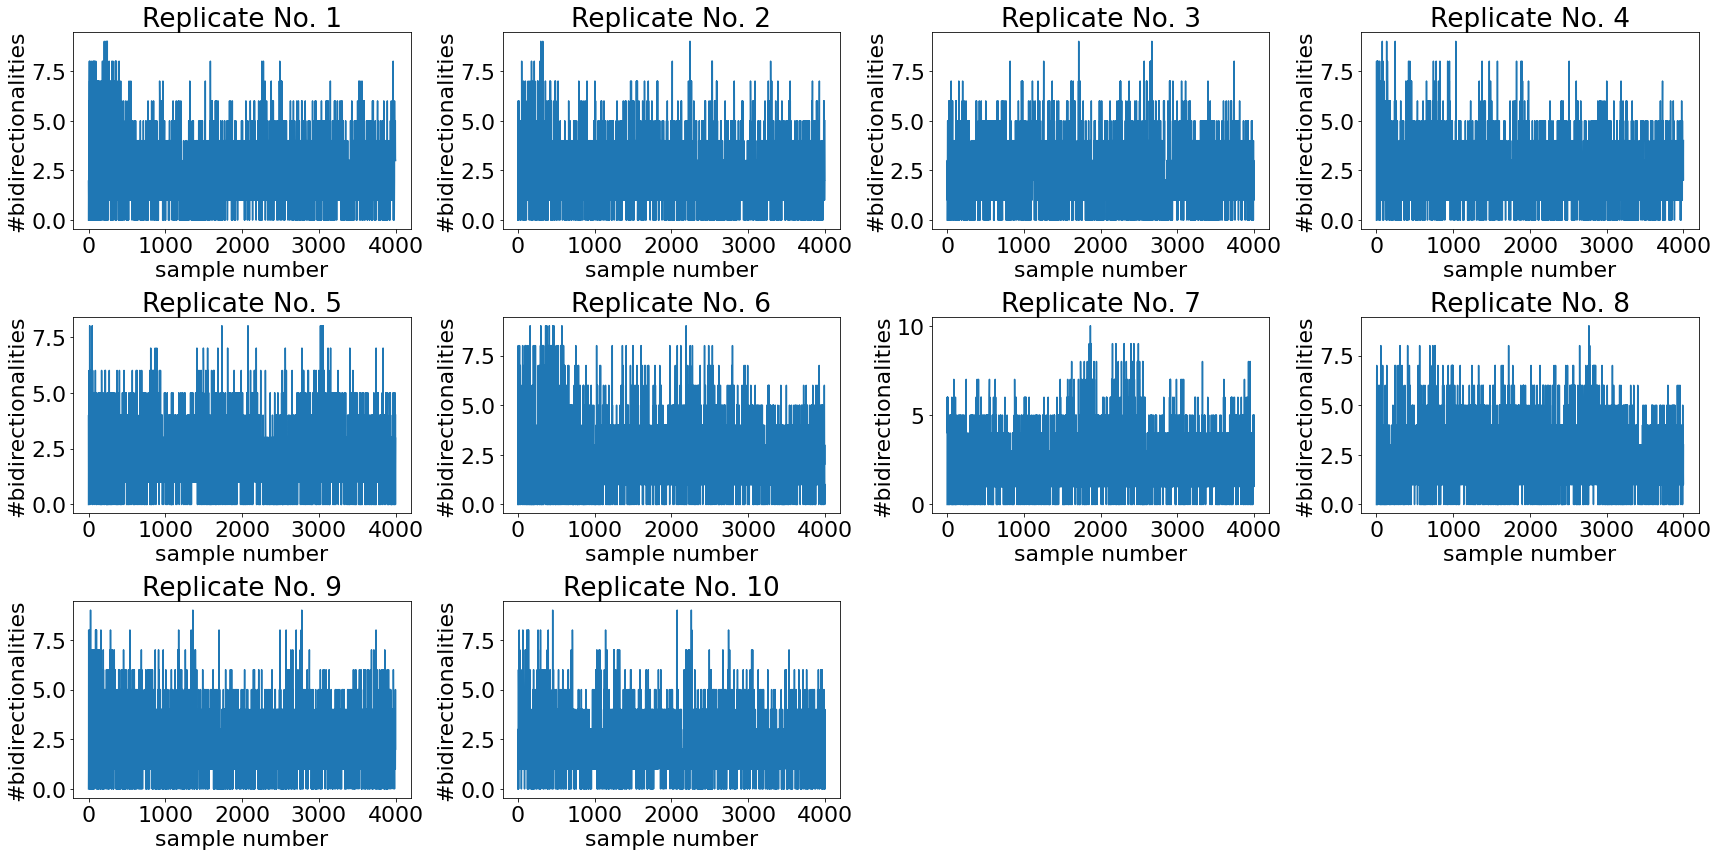

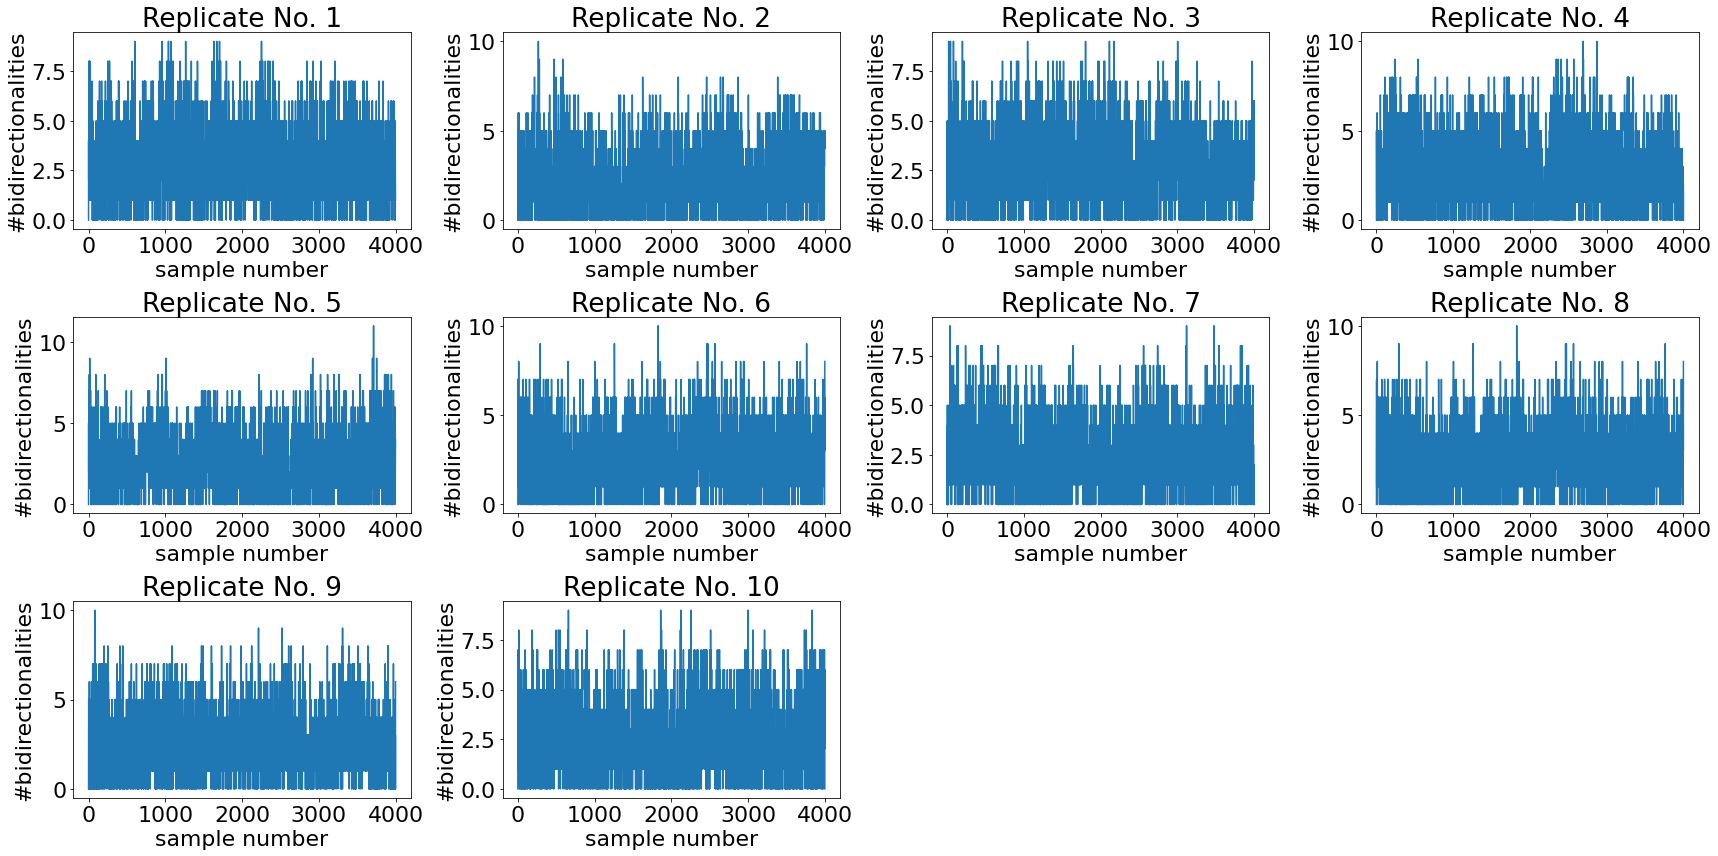

In [15]:
# settings for plot
num_cols = 4
num_rows = int(np.ceil(NUM_CHAINS / num_cols))
ratio = 1.5
size_fac = 4
fs = 22

for cond in CONDITIONS:
    # create subplots
    fig, ax = plt.subplots(
        num_rows, num_cols, figsize=(ratio * size_fac * num_cols, size_fac * num_rows)
    )
    last_col = 0

    # for each chain
    for i in range(NUM_CHAINS):
        # get all xchfluxes
        xchfluxes = fluxes_raw[cond][i].filter(like=".x", axis=1)
        # mark if xch flux is active or not
        binxchfluxes = pd.DataFrame(
            data=xchfluxes.values != 0, columns=xchfluxes.columns
        )
        # calculate the model mixingin
        # 1. diff: columnwise (i.e. from sample to sample) record changes
        # 2. abs: do not distinguish the direction of the change
        # 3. sum: sum up the total number of chnages
        model_mix = binxchfluxes.diff().abs().sum(axis="columns")

        # prepare plot
        row = int(np.floor(i / num_cols))
        col = int(i % num_cols)
        last_col = col
        # plot
        model_mix.plot(ax=ax[row, col])
        # format plot
        ax[row, col].tick_params(axis="both", labelsize=fs)
        ax[row, col].set_title("Replicate No. {0}".format(i + 1), fontsize=1.2 * fs)
        ax[row, col].set_xlabel("sample number", fontsize=fs)
        ax[row, col].set_ylabel("#bidirectionalities", fontsize=fs)

    # remove the unneeded empty plots
    for col in range(last_col + 1, num_cols):
        ax[-1, col].axis("off")
    plt.tight_layout()
    part = "A"
    if cond == CONDITIONS[1]:
        part = "B"
    plt.savefig(f"out/Fig_S09{part}_model_mixing_plot.svg")
    plt.savefig(f"out/Fig_S09{part}_model_mixing_plot.png")
    plt.savefig(f"out/Fig_S09{part}_model_mixing_plot.pdf")